In [76]:
# imports and configs

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# make plots a bit bigger
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 20]

# make cells wider
# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# control how data is display in pandas
# https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
print(pd.options.display.max_rows)
print(pd.options.display.expand_frame_repr)
pd.options.display.max_rows = 20
pd.options.display.expand_frame_repr = False

20
False


In [100]:
# --------------------------------------------------
# load the datasets

df_c = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")
df_d = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
df_r = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv")

# --------------------------------------------------
# next rotate them to add a Date column

ids = ['Country/Region', 'Province/State', 'Lat', 'Long']

df_c = df_c.melt(id_vars=ids, var_name="Date", value_name="Confirmed")
df_d = df_d.melt(id_vars=ids, var_name="Date", value_name="Deaths")
df_r = df_r.melt(id_vars=ids, var_name="Date", value_name="Recovered")

# --------------------------------------------------
# next merge the Confirmed/Deaths/Recovered into one dataframe

# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
keys = ids + ["Date"]

df = pd.merge(df_c, df_d, how='outer', on=keys)
df = pd.merge(df, df_r, how='outer', on=keys)

# --------------------------------------------------
# ad an active column

df['Active'] = df['Confirmed'] - (df['Recovered'] + df['Deaths'])

# --------------------------------------------------
# some countries have no Province/State, we need empty strings

df['Province/State'] = df['Province/State'].fillna('')

# --------------------------------------------------
# finally cleanup the dates (who uses M/D/Y in a dataset ???)

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')

# --------------------------------------------------
# add an Id column

df['Id'] = df['Country/Region'] + '-' + df['Province/State']

# --------------------------------------------------
# add Increase columns

numericalbase = ['Confirmed', 'Deaths', 'Recovered', 'Active']
numericalcolors = { 'Confirmed':'blue',
                    'Deaths':   'red',
                    'Recovered':'green',
                    'Active':   'orange' }

numerical = []
gb = df.groupby('Id')
for n in numericalbase:
    numerical.append(n)
    
    ni = '%sIncrease' % n
    df[ni] = gb[n].diff()
    numerical.append(ni)
    
    #na = '%sAvg' % n
    #df[na] = gb[n].apply(pd.rolling_mean, 3, min_periods=1)
    #df[na] = gb[n].transform('cumsum')
    #numericalx.append(na)
    
# --------------------------------------------------
# these are the columns we may want to sum later

aggregation = {}
for n in numerical:
    aggregation[n] = 'sum'

# --------------------------------------------------
# fix column order

cols = ['Id'] + keys + numerical

df = df[cols]

# --------------------------------------------------
# sort by Confirmed column

#df = df.sort_values(by=['Date', 'Confirmed'])

# --------------------------------------------------
# write it for review

df.to_csv("csse-combined.csv", index=False)

# --------------------------------------------------
# dump

#for c in df.columns:
#    u = df[c].unique()
#    print("%-20s %u" % (c, len(u)))

#print(df['Country/Region'].unique())

df.describe(include="all")

,Id,Country/Region,Province/State,Lat,Long,Date,Confirmed,ConfirmedIncrease,Deaths,DeathsIncrease,Recovered,RecoveredIncrease,Active,ActiveIncrease
count,31062,31062,31062,31062.000000,31062.000000,31062,30870.000000,30369.000000,30870.000000,30369.000000,30870.000000,30369.000000,30870.000000,30369.000000
unique,501,183,326,NaN,NaN,62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,United Kingdom-Montserrat,US,,NaN,NaN,2020-01-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,62,15438,10788,NaN,NaN,501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,2020-01-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2020-03-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,30.285772,-33.097762,NaN,179.214156,11.045869,6.377583,0.481610,64.171785,3.237051,108.664788,7.327209
std,NaN,NaN,NaN,19.851022,80.581967,NaN,2605.672614,168.719595,122.954763,10.868869,1417.219797,64.652431,1514.280205,155.065792
min,NaN,NaN,NaN,-41.454500,-157.858400,NaN,0.000000,-98.000000,0.000000,-17.000000,0.000000,-30.000000,-177.000000,-2743.000000
25%,NaN,NaN,NaN,23.341700,-90.230800,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


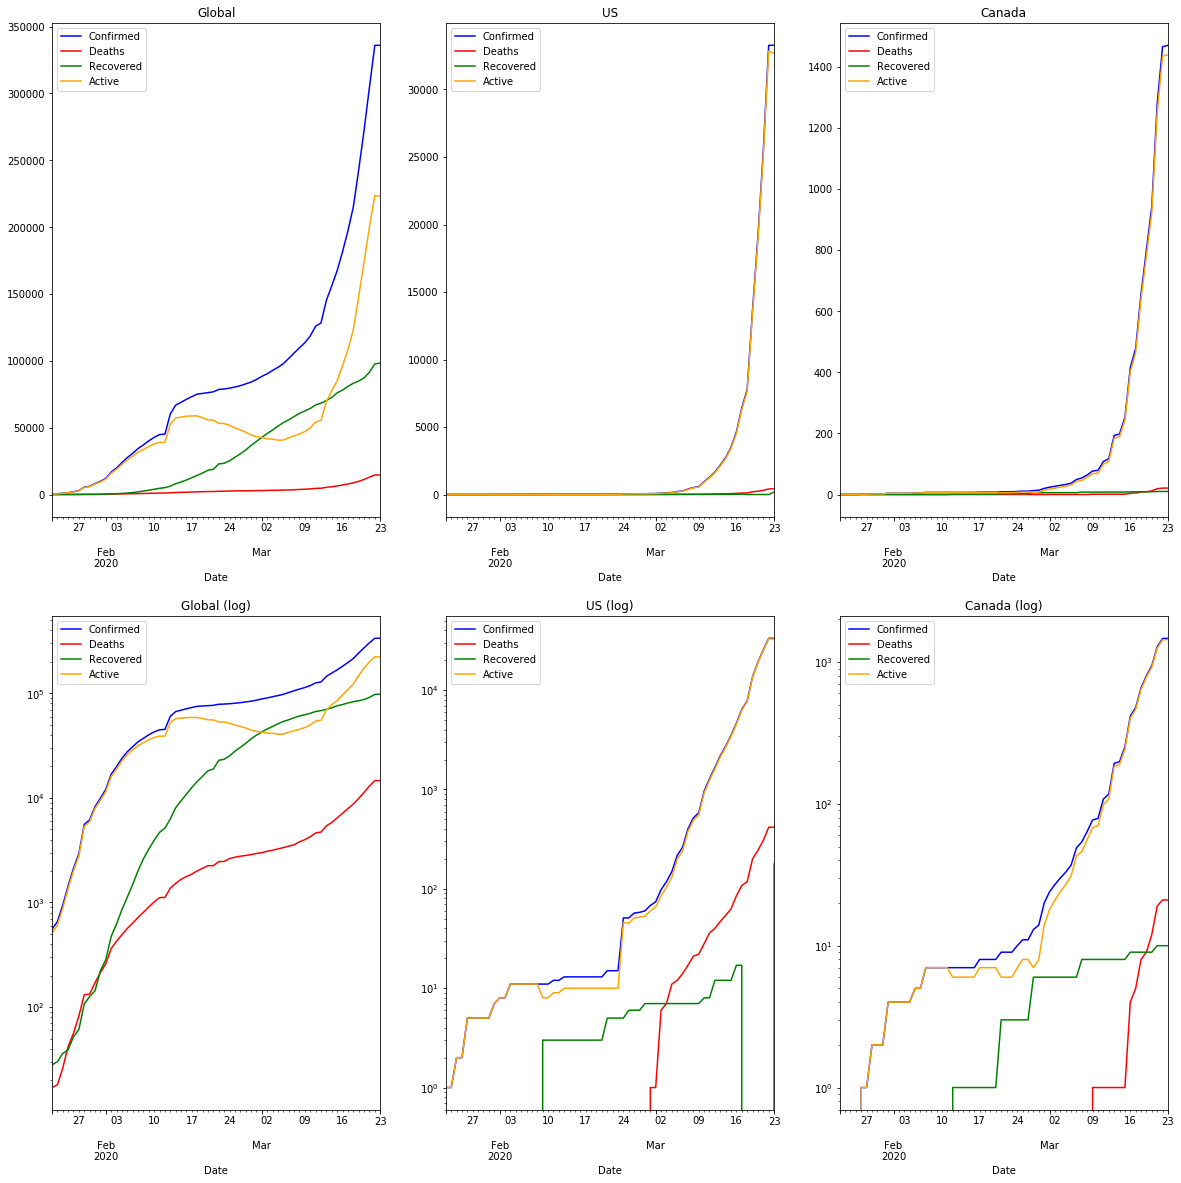

In [102]:
gbl = df.groupby(['Date'],as_index=False).agg(aggregation)

cdn = df.loc[df['Country/Region'] == 'Canada']
cdn = cdn.groupby(['Country/Region','Date'],as_index=False).agg(aggregation)

usa = df.loc[df['Country/Region'] == 'US']
usa = usa.groupby(['Country/Region','Date'],as_index=False).agg(aggregation)

DATA = [{'n':'Global', 'df':gbl},
        {'n':'US',     'df':usa},
        {'n':'Canada', 'df':cdn}]

fig, axs = plt.subplots(2, len(DATA))

i=0
for d in DATA:
    p = d['df']
    
    ax = axs[0][i]
    ax.set_title(d['n'])
    for col in numericalbase:
        p.plot(kind='line',x='Date',y=col, color=numericalcolors[col], ax=ax)

    ax = axs[1][i]
    ax.set_yscale('log')
    ax.set_title("%s (log)" % d['n'])
    for col in numericalbase:
        p.plot(kind='line',x='Date',y=col, color=numericalcolors[col], ax=ax)

    i = i+1

plt.show()


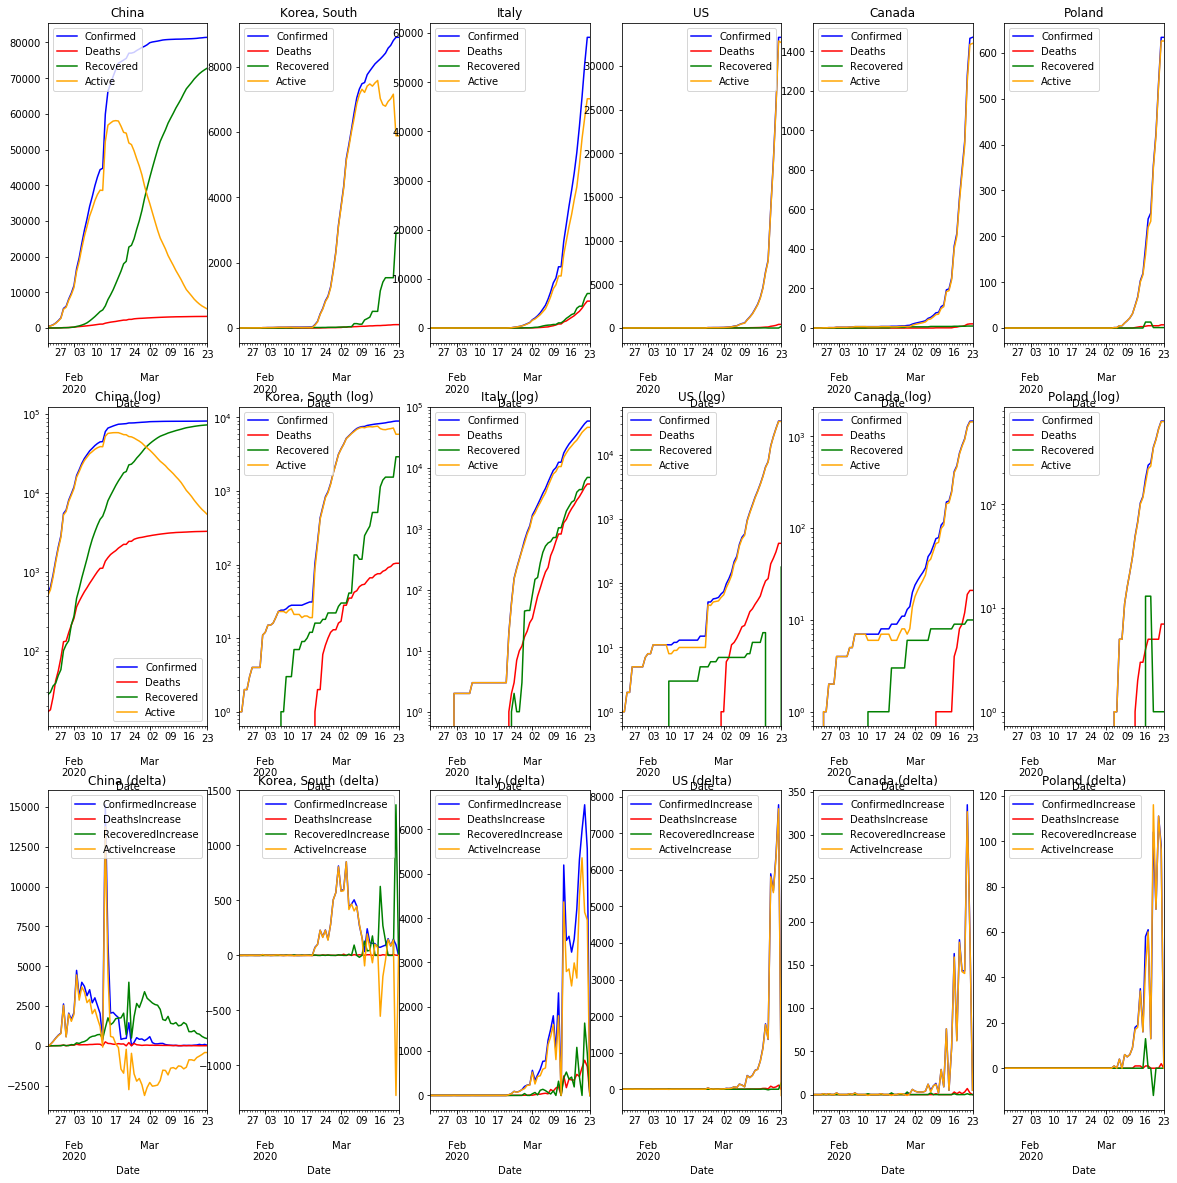

In [103]:
#print(df['Country/Region'].unique())
countries = ['China', 'Korea, South', 'Italy', 'US', 'Canada', 'Poland']

fig, axs = plt.subplots(3, len(countries))

i = 0
for country in countries:
    p = df.loc[df['Country/Region'] == country]
    p = p.groupby(['Country/Region','Date'],as_index=False).agg(aggregation)

    ax = axs[0][i]
    ax.set_title(country)
    for col in numericalbase:
        p.plot(kind='line',x='Date',y=col, color=numericalcolors[col], ax=ax)


    ax = axs[1][i]
    ax.set_yscale('log')
    ax.set_title("%s (log)" % country)
    for col in numericalbase:
        p.plot(kind='line',x='Date',y=col, color=numericalcolors[col], ax=ax)

    ax = axs[2][i]
    ax.set_title("%s (delta)" % country)
    for col in numericalbase:
        p.plot(kind='line',x='Date',y="%sIncrease"%col, color=numericalcolors[col], ax=ax)

    i = i + 1

fig.savefig('out/countries.png')
plt.show()


['British Columbia' 'Ontario' 'Alberta' 'Quebec' 'New Brunswick']


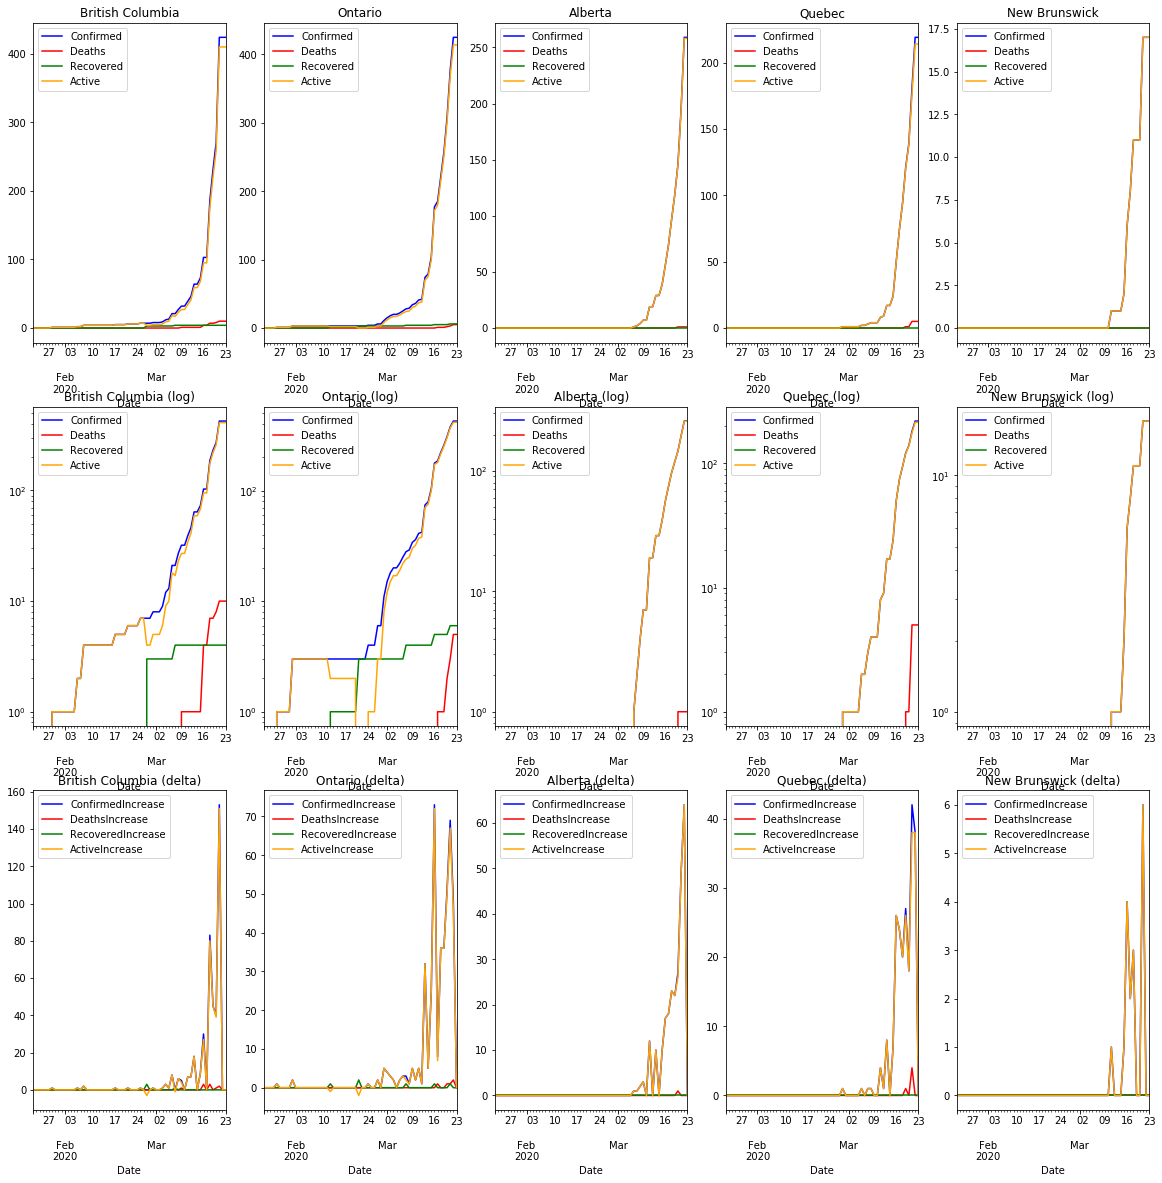

In [104]:
country = 'Canada'
cdf = df.loc[df['Country/Region'] == country]
regions = cdf['Province/State'].unique()
regions = regions[0:5]

print(regions)

fig, axs = plt.subplots(3, len(regions))

i = 0
for region in regions:
    d = cdf.loc[df['Province/State'] == region]

    p = d.groupby(['Province/State','Date'],as_index=False).agg(aggregation)

    #print(p)
    
    ax = axs[0][i]
    ax.set_title(region)
    for col in numericalbase:
        p.plot(kind='line',x='Date',y=col, color=numericalcolors[col], ax=ax)

    ax = axs[1][i]
    ax.set_yscale('log')
    ax.set_title("%s (log)" % region)
    for col in numericalbase:
        p.plot(kind='line',x='Date',y=col, color=numericalcolors[col], ax=ax)

    ax = axs[2][i]
    ax.set_title("%s (delta)" % region)
    for col in numericalbase:
        p.plot(kind='line',x='Date',y="%sIncrease"%col, color=numericalcolors[col], ax=ax)

    i = i + 1


fig.savefig('out/canada.png')
plt.show()
